#Dynamic signs classification of MSL using CNN-3D

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


## Libraries

In [2]:
import keras
from keras import datasets, layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import cv2
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization

## Dataset information

Get information from GitHub repository

In [3]:
!git clone https://github.com/artLara/LSM-CNN3D.git

Cloning into 'LSM-CNN3D'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 118 (delta 11), reused 107 (delta 6), pack-reused 0
Receiving objects: 100% (118/118), 15.99 MiB | 24.22 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [4]:
%cd LSM-CNN3D/
!ls

/content/LSM-CNN3D
data_aumentation.py  dataset.csv  README.md  split_dataset.py  test.csv  train.csv  videos


In [5]:
df = pd.read_csv('/content/LSM-CNN3D/dataset.csv')

In [6]:
print(df.count())

Name     80
Class    80
dtype: int64


## Load train and test datasets

In [7]:
train = pd.read_csv('/content/LSM-CNN3D/train.csv')
test = pd.read_csv('/content/LSM-CNN3D/test.csv')

In [8]:
train

,Name,Class
0,persona1/bien.mp4,bien
1,persona1/comoEstas.mp4,comoEstas
2,persona1/duda.mp4,duda
3,persona1/examen.mp4,examen
4,persona1/hola.mp4,hola
...,...,...
65,persona8/examen.mp4,examen
66,persona8/hola.mp4,hola
67,persona8/mal.mp4,mal
68,persona8/mandar.mp4,mandar


In [48]:
def showFrame(videoName, indexFrame, path = ''):
    """
      Description: This fuction show a specific frame of video

      Input:
        - videoName: file name of video
        - indexFrame: index frame which will be shown
        - path: path of directory which contains video folders
    """
    vidcap = cv2.VideoCapture(path + videoName)
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, indexFrame)
    ret, frame = vidcap.read()
    plt.imshow(frame)

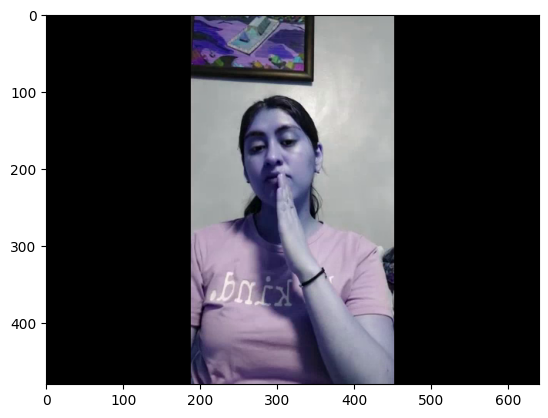

In [63]:
showFrame(train['Name'][20], 10, path='/content/LSM-CNN3D/videos/')

In [9]:
test

,Name,Class
0,persona1/avisame.mp4,avisame
1,persona1/buenosDias.mp4,buenosDias
2,persona2/bien.mp4,bien
3,persona2/comoEstas.mp4,comoEstas
4,persona2/duda.mp4,duda
5,persona3/examen.mp4,examen
6,persona3/hola.mp4,hola
7,persona4/mal.mp4,mal
8,persona4/mandar.mp4,mandar
9,persona4/whatsapp.mp4,whatsapp


## Pre-processing

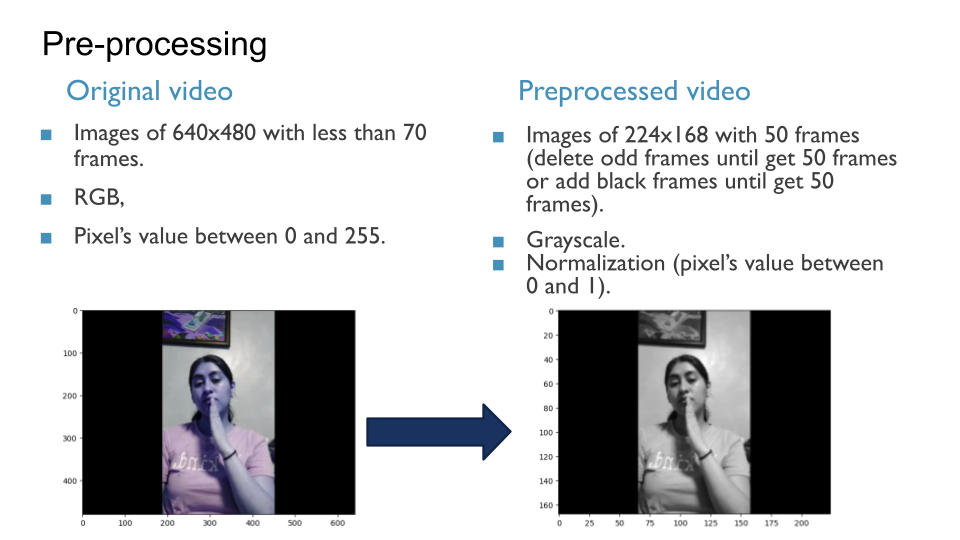

### Parameters of pre-processng

In [10]:
MAX_FRAMES = 50 #Maximum frames of videos
scale = 0.35 #Scale  for resizing
dim = (int(640*scale), int(480*scale)) #(width, hight)
dim3d = (int(480*scale), int(640*scale))

In [11]:
dim3d

(168, 224)

In [12]:
# input_shape = (MAX_FRAMES, dim3d[0], dim3d[1], dim3d[2])
input_shape = (MAX_FRAMES, dim3d[0], dim3d[1], 1)

### Pre-processing videos

In [13]:
def preprocessingVideos(df, path=''):
    """
      Description: This function preprocessing videos in a dataframe.

      Input:
        - df: dataframe of videos (train, test or validation)
        - path: path of directory which contains video folders

      Global variables:
        - MAX_FRAMES: max frames possibles

      Output:
        x: frames preprocessed in numpy array
    """
    x=[]
    num=0

    for name in df['Name']:
        frames = []
        vidcap = cv2.VideoCapture(path + name)
        success,image = vidcap.read()
        count = 0
        while success:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
            image = image.astype('float32') / 255.0
            frames.append(image)
            success,image = vidcap.read()
        # print('Video', name, 'total frames', len(frames))
        if len(frames) < MAX_FRAMES:
            newFrames = []
            indexFrames=0
            for f in range(0, MAX_FRAMES):
                #Add black frames at left of video
                if f < (MAX_FRAMES-len(frames))//2:
                    blackFrame = np.zeros(dim3d)
                    blackFrame = blackFrame.astype('float32') / 255.0
                    newFrames.append(blackFrame)

                #Add black frames at right of video
                elif f >= (MAX_FRAMES-len(frames))//2 + len(frames):
                    blackFrame = np.zeros(dim3d)
                    blackFrame = blackFrame.astype('float32') / 255.0
                    newFrames.append(blackFrame)

                #Add frames of video
                else:
                    newFrames.append(frames[indexFrames])
                    indexFrames += 1
            frames = newFrames

        elif len(frames) > MAX_FRAMES:
            newFrames = []
            frames_to_delete = MAX_FRAMES-len(frames)
            index = 1
            while True:
                if len(frames) == MAX_FRAMES or index>=len(frames):
                    break
                frames.pop(index)
                index += 1
        x.append(np.asarray(frames))

    return np.asarray(x, dtype=np.float32)

In [52]:
x_train = preprocessingVideos(train, path='/content/LSM-CNN3D/videos/')
print(x_train.shape)

(70, 50, 168, 224)


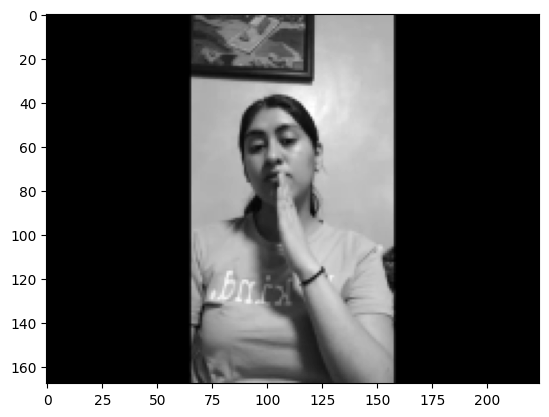

In [64]:
plt.imshow(x_train[20][20], cmap='gray')

In [ ]:
x_test = preprocessingVideos(test, path='/content/LSM-CNN3D/videos/')
print(x_test.shape)

(10, 50, 168, 224)


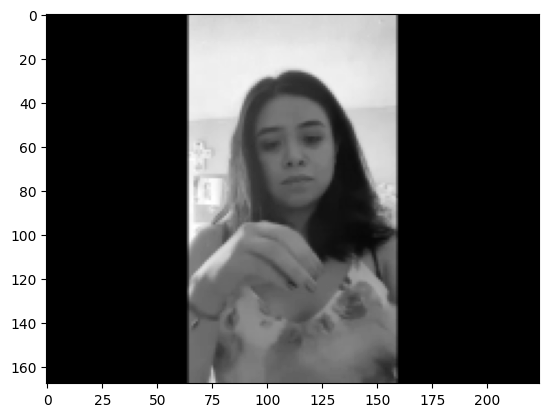

In [ ]:
plt.imshow(x_test[8][16], cmap='gray')

### Train targets

In [ ]:
y_train=[]
for label in train['Class']:
    y_train.append(label)

y_train=np.asarray(y_train)
len(y_train)

70

In [ ]:
y_train[1]

'comoEstas'

### Test targets

In [ ]:
y_test=[]
for label in test['Class']:
    y_test.append(label)

y_test=np.asarray(y_test)

In [ ]:
y_test[0]

'avisame'

### One-hot encoding for targets

In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train_onehot = onehot_encoder.fit_transform(y_train)

y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoder.fit_transform(y_test)

y_train_onehot.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(70, 10)

In [ ]:
y_test_onehot.shape

(10, 10)

## Classification

### CNN-3D Architecture

In [ ]:
model = models.Sequential()

#Layer 1
model.add(Conv3D(6, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
#Layer 2
model.add(Conv3D(6, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
#Layer 3
model.add(Conv3D(6, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
# Maxpooling
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#Layer 4
model.add(Conv3D(10, kernel_size=(3, 3, 3), activation='relu'))
# Maxpooling
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#Layer 5
model.add(Conv3D(12, kernel_size=(3, 3, 3), activation='relu'))
# Maxpooling
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# Maxpooling
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# Flatting
model.add(layers.Flatten())
#Fully contected
model.add(layers.Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(30, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

### Building and training model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train_onehot, epochs=200,
                    validation_data=(x_test, y_test_onehot))

Epoch 1/200
3/3 [==============================] - 12s 2s/step - loss: 2.2992 - accuracy: 0.0571 - val_loss: 2.3265 - val_accuracy: 0.1000
Epoch 2/200
3/3 [==============================] - 4s 1s/step - loss: 2.3181 - accuracy: 0.1286 - val_loss: 2.3100 - val_accuracy: 0.0000e+00
Epoch 3/200
3/3 [==============================] - 4s 1s/step - loss: 2.3243 - accuracy: 0.0714 - val_loss: 2.3061 - val_accuracy: 0.1000
Epoch 4/200
3/3 [==============================] - 4s 1s/step - loss: 2.3080 - accuracy: 0.0571 - val_loss: 2.3048 - val_accuracy: 0.0000e+00
Epoch 5/200
3/3 [==============================] - 4s 1s/step - loss: 2.2937 - accuracy: 0.1571 - val_loss: 2.3053 - val_accuracy: 0.1000
Epoch 6/200
3/3 [==============================] - 4s 1s/step - loss: 2.3087 - accuracy: 0.1143 - val_loss: 2.3058 - val_accuracy: 0.1000
Epoch 7/200
3/3 [==============================] - 4s 1s/step - loss: 2.3012 - accuracy: 0.0571 - val_loss: 2.3069 - val_accuracy: 0.1000
Epoch 8/200
3/3 [========

### Saving model

In [ ]:
model.save('model_gray.h5')

## Evaluation

1/1 - 0s - loss: 2.0176 - accuracy: 0.7000 - 182ms/epoch - 182ms/step


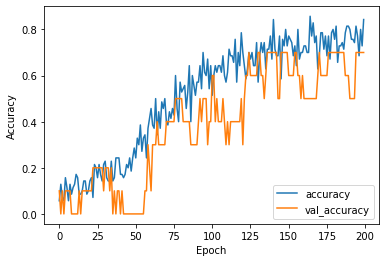

In [ ]:
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label = 'Prueba')
plt.xlabel('Épocas')
plt.ylabel('Prcsisión')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test_onehot, verbose=2)